# 1: LDA TFIDF - topic exploration

<ol>
  <p>1  -    scientific, investigation, soco, attendance  </p>
  <p>2  -    careless, disposal, smoking, bin, cigarette  </p>
  <p>4  -    fit, cid, proceeding, police </p>
  <p>5  -    dishwasher, appliance, model, recall  </p>
  <p>6  -    ignition, area, source, evidence  </p>
  <p>7  -    dryer, tumble, sheets, towels  </p>
  <p>8  -    police, investigating, pc, attached  </p>
  <p>9  -    police, petrol, door, derelict  </p>
  <p>10 -    shed, garden, ignited, spread  </p>
  <p>11 -    smoke, flat, floor, attended  </p>
  <p>12 -    pan, occupier, left, unattended  </p>
  <p>13 -    heater, fan, boiler, motor  </p>
  <p>14 -    vehicle, car, garage, engine  </p>
  <p>15 -    connection, electrical, resistance, fridge  </p>
  <p>16 -    lamp, light, fitting, loft  </p>
  <p>17 -    candle, lfet, tv, toaster </p>
  <p>18 -    returned, machine, washing, pending </p>
  <p>19 -    gas, hob, cooker, oven </p>
  <p>20 -    electrical, consumer, fuse, supply </p>
</ol>

In [70]:
import sys
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
import pickle

from corpus_extractor import *

import data_cleaning
from data_cleaning import *

import topic_modellor
from topic_modellor import *

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)
%pylab inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


### load data, corpus, and model

In [71]:
lfb = pd.read_csv('../data/lfb_all_primary_fire_data.csv')
lfb = convert_date_time(lfb)

lfb['year'] = lfb['DDDateTimeOfCall'].dt.year
lfb['month'] = lfb['DDDateTimeOfCall'].dt.month
lfb['weekday'] = lfb['DDDateTimeOfCall'].dt.weekday
lfb['year-month'] = lfb['DDDateTimeOfCall'].map(lambda x: x.strftime('%Y-%m'))

In [72]:
corpus = pd.read_csv('../corpus/corpus.txt')
preprocesed = pd.read_csv('../corpus/preprocessed.txt')
vector, vector_fit, model = pickle.load(open("../model/model_pickled.p", "rb"))

### prepare topics data_frame

In [73]:
lfb_free_text = CorpusExtractor().extract_free_text_only_data_frame(lfb)

lfb_free_text['year'] = lfb_free_text['DDDateTimeOfCall'].dt.year
lfb_free_text['month'] = lfb_free_text['DDDateTimeOfCall'].dt.month
lfb_free_text['weekday'] = lfb_free_text['DDDateTimeOfCall'].dt.weekday
lfb_free_text['year-month'] = lfb_free_text['DDDateTimeOfCall'].map(lambda x: x.strftime('%Y-%m'))

topic_classified = classify_model_topics(model, vector_fit)
lfb_free_text['topic'] = topic_classified.values

### mean topic probabilities each year

In [74]:
topic_probabilities = get_topic_probabilities(model, vector_fit)

In [75]:
probabilities = pd.concat([lfb_free_text.reset_index(drop=True)['year'], topic_probabilities], axis=1)

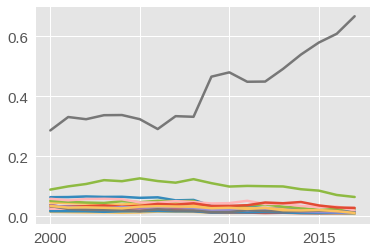

In [76]:
df2 = probabilities.groupby('year').mean()
df2.index.name = None

plt.plot(df2.iloc[:,0:19])

## Incident topics in 36833 document corpus

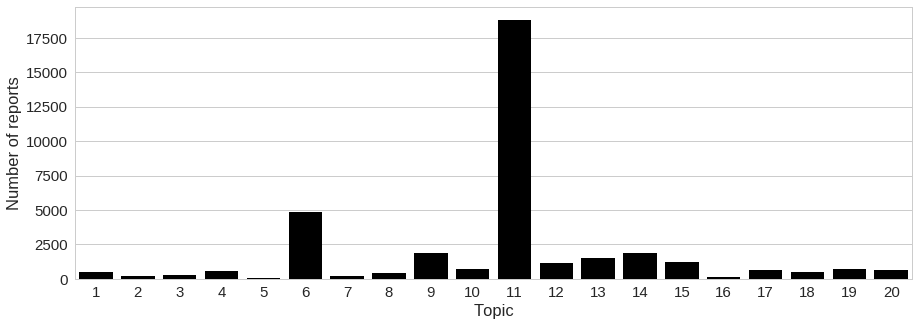

In [77]:
df = lfb_free_text.topic.value_counts()
plt.figure(figsize=(15, 5))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = sns.barplot(x=df.index,y=df.values, color="black")
ax.set(xlabel='Topic', ylabel='Number of reports')
sns.plt.show()

## word counts

In [78]:
df = lfb_free_text
words_brief_description = df['BriefDescriptionOfFire'].str.split().str.len()
words_further_info = df['FurtherInformation'].str.split().str.len()
word_count = words_brief_description.fillna(0) + words_further_info.fillna(0)
df['word_count'] = word_count

(0, 600)

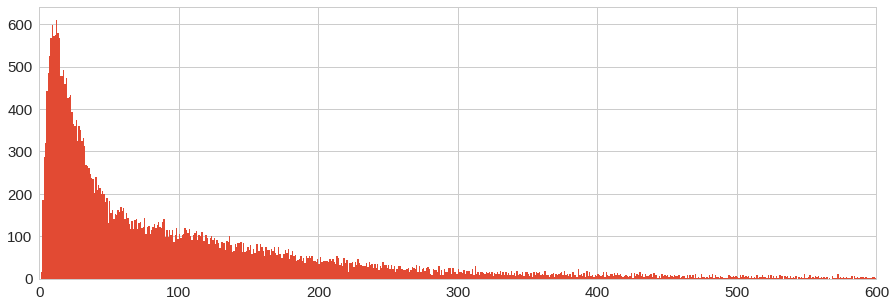

In [79]:
plt.figure(figsize=(15, 5))
plt.hist(df['word_count'], bins=range(1, int(df.word_count.max())))
plt.xlim([0,600])

### mean document length each year

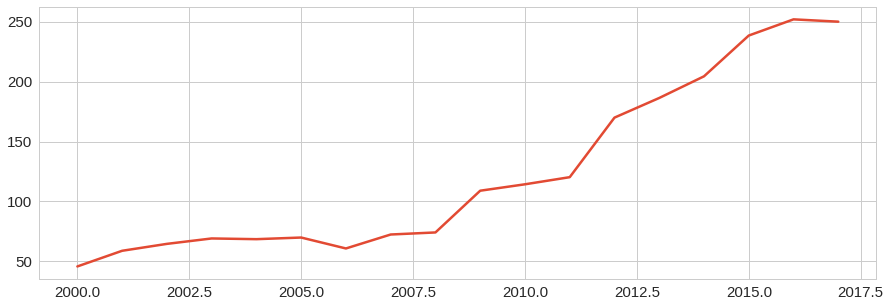

In [80]:
plt.figure(figsize=(15, 5))
df2 = df[['word_count','year']].groupby(['year']).mean()
plt.plot(df2)

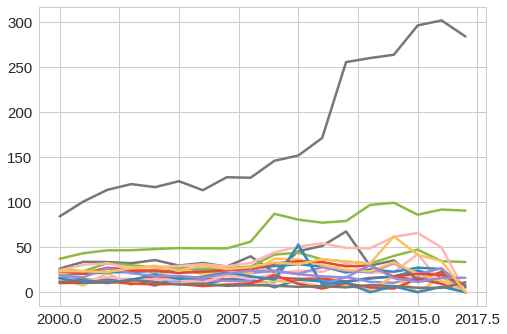

In [81]:
df2 = df[['year','topic','word_count']].pivot_table(index='year', columns='topic', aggfunc=mean, fill_value=0) 
df2.index.name = None
plt.plot(df2.iloc[:,0:19])

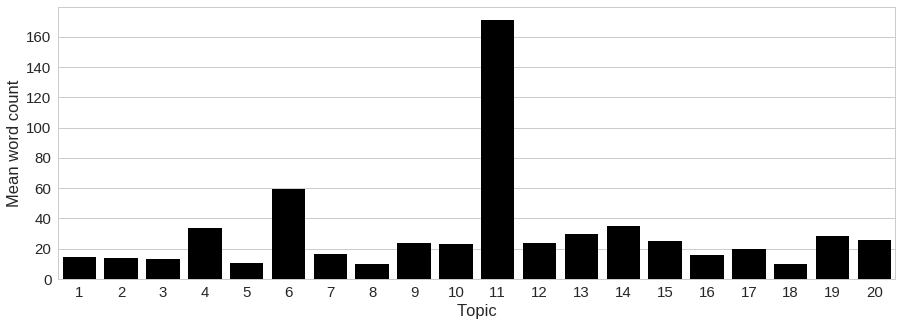

In [82]:
df2 = df[['topic','word_count']].groupby(['topic']).mean()
df2.reset_index(inplace=True)
plt.figure(figsize=(15, 5))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = sns.barplot(x=df2.topic,y=df2.word_count, color="black")
ax.set(xlabel='Topic', ylabel='Mean word count')
sns.plt.show()

## Did fire investigation attend?

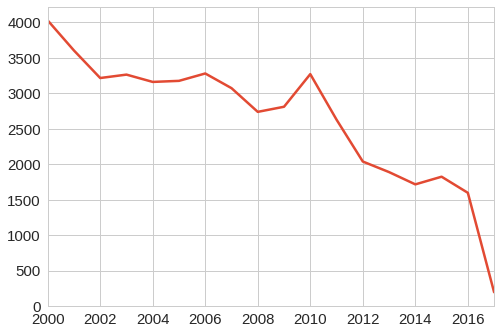

In [83]:
df = lfb
df = df[['year','DidFireInvestigationAttend']].pivot_table(index='year', columns='DidFireInvestigationAttend', aggfunc=len, fill_value=0)
df.index.name = None
df.Yes.plot()

## Was a report written?

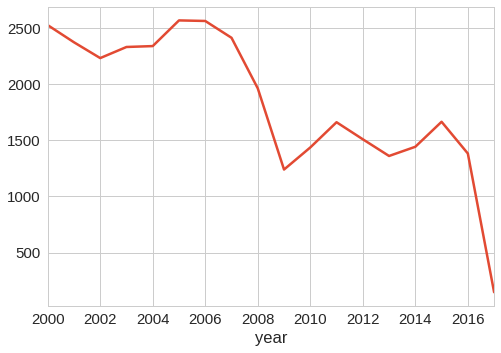

In [84]:
df = lfb
df = df[['year','BriefDescriptionOfFire','FurtherInformation']]
df['text'] = df['BriefDescriptionOfFire'].map(str) + df['FurtherInformation']
df = df.groupby('year').agg({'text': lambda x: x.notnull().sum(), 'year': 'count'})
df.text.plot()

## Stacked area plot of topic occurence Year-month

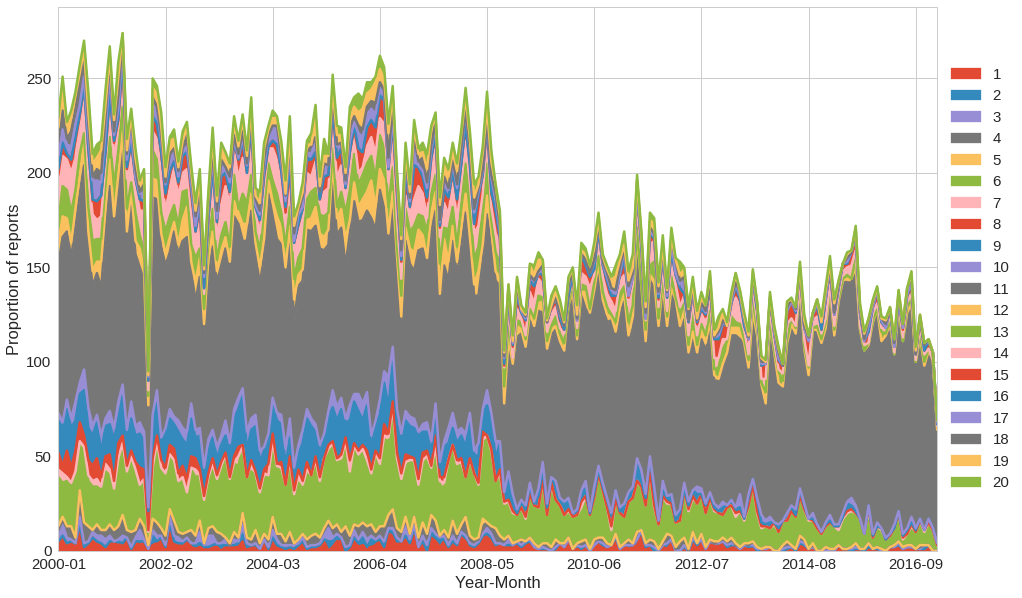

In [85]:
df = lfb_free_text
df = df[['year-month','topic']].pivot_table(index='year-month', columns='topic', aggfunc=len, fill_value=0)
df.index.name = None
ax = df.plot.area(figsize=(15, 10));
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.05, box.height])
ax.set(xlabel='Year-Month', ylabel='Proportion of reports')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#savefig('topics_stacked_area_plot.png', bbox_inches='tight')

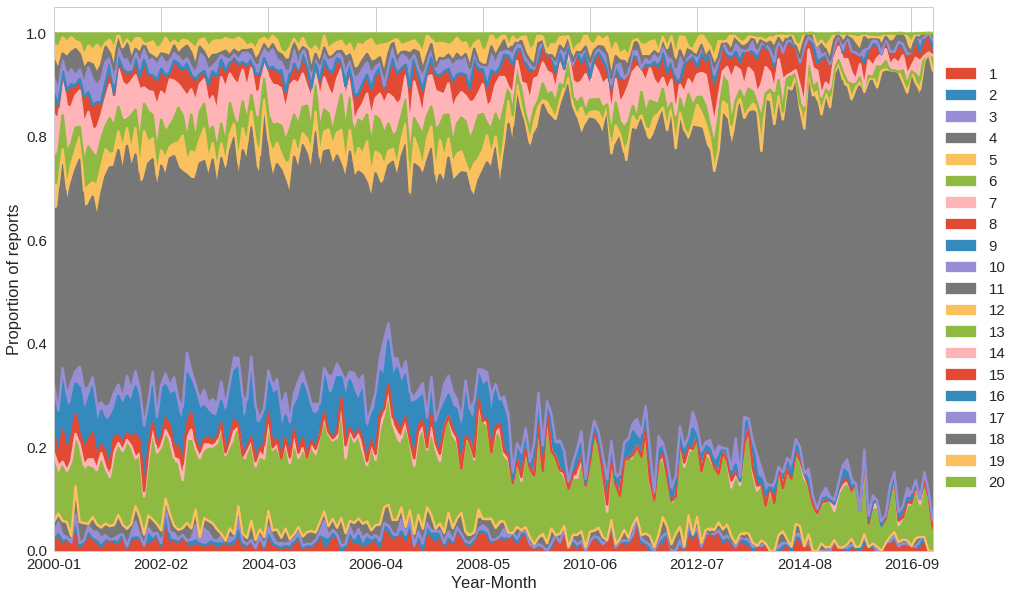

In [86]:
df = lfb_free_text
df2 = df[['year-month','topic']].pivot_table(index='year-month', columns='topic', aggfunc=len, fill_value=0)
df2.index.name = None
df2["sum"] = df2.sum(axis=1)
df2 = df2.iloc[:,0:df.topic.max()].div(df2["sum"], axis=0)
ax = df2.plot.area(figsize=(15, 10));
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.05, box.height])
ax.set(xlabel='Year-Month', ylabel='Proportion of reports')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Stacked area plot of topic occurence month

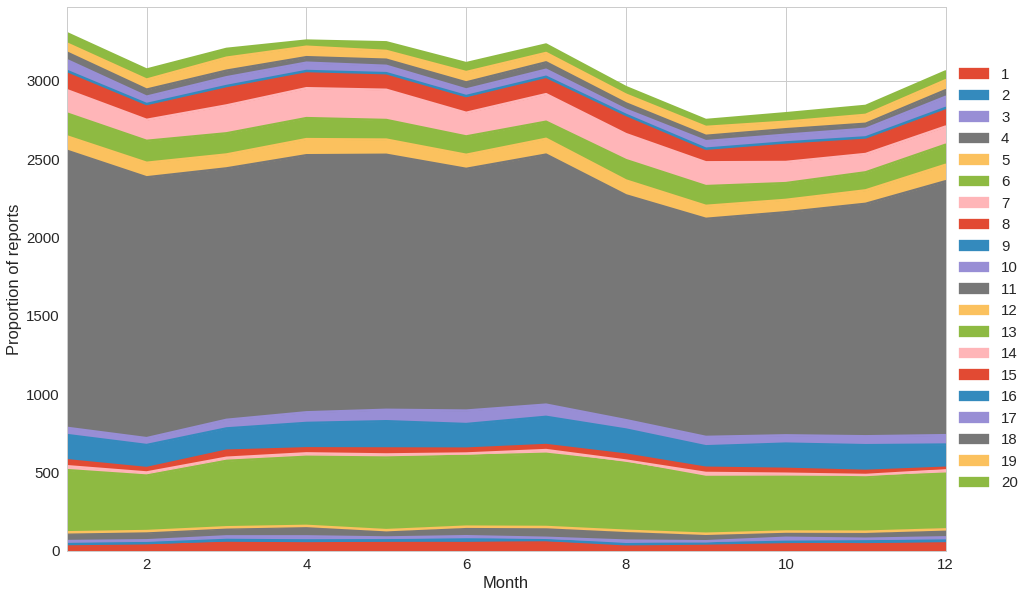

In [87]:
df = lfb_free_text
df = df[['month','topic']].pivot_table(index='month', columns='topic', aggfunc=len, fill_value=0)
df.index.name = None
ax = df.plot.area(figsize=(15, 10));
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.05, box.height])
ax.set(xlabel='Month', ylabel='Proportion of reports')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

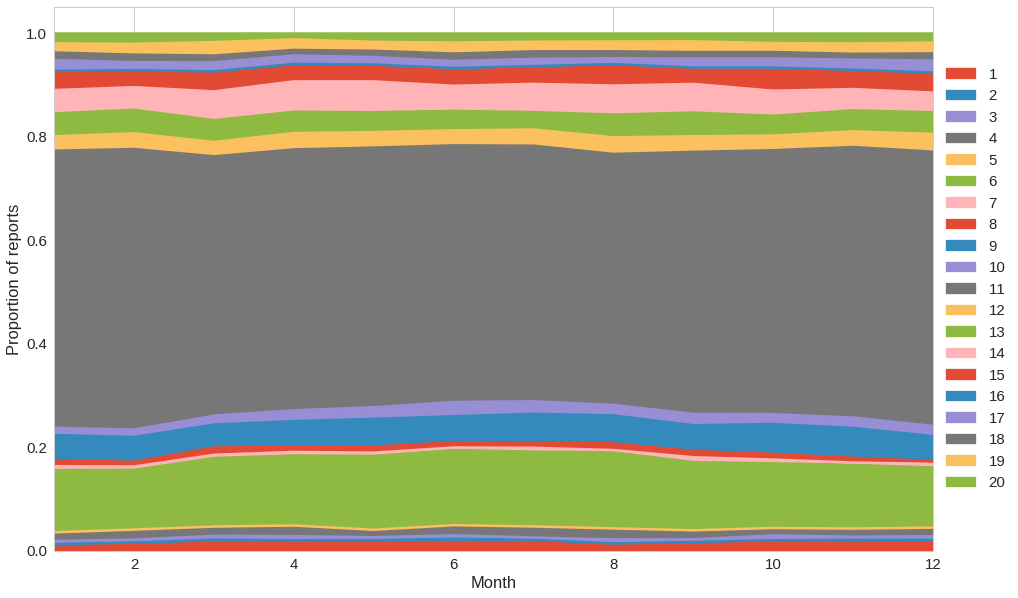

In [88]:
df = lfb_free_text
df2 = df[['month','topic']].pivot_table(index='month', columns='topic', aggfunc=len, fill_value=0)
df2.index.name = None
df2["sum"] = df2.sum(axis=1)
df2 = df2.iloc[:,0:df.topic.max()].div(df2["sum"], axis=0)
ax = df2.plot.area(figsize=(15, 10));
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.05, box.height])
ax.set(xlabel='Month', ylabel='Proportion of reports')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Stacked area plot of topic occurence year

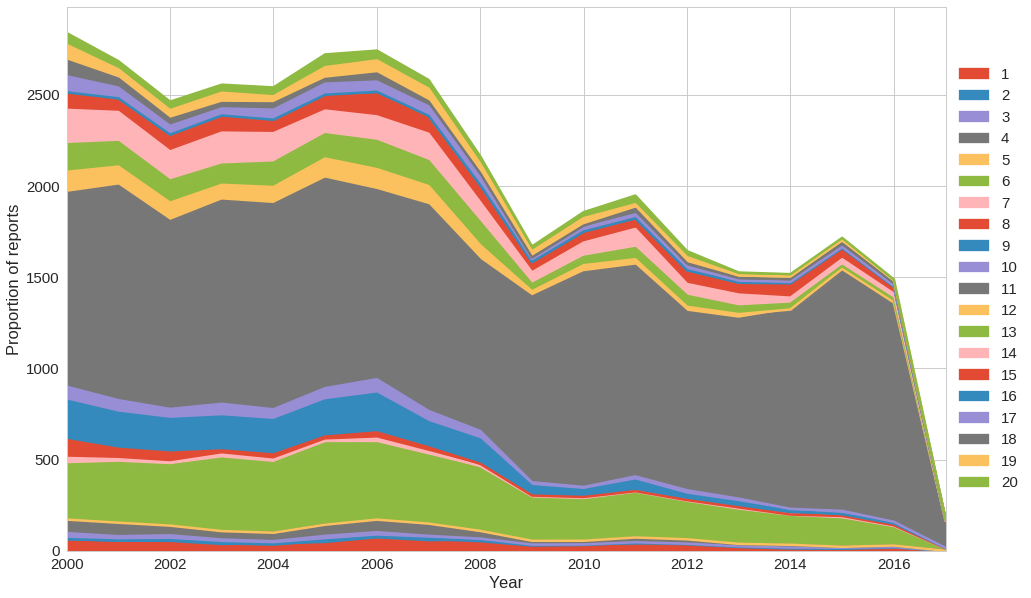

In [89]:
df = lfb_free_text
df = df[['year','topic']].pivot_table(index='year', columns='topic', aggfunc=len, fill_value=0)
df.index.name = None
ax = df.plot.area(figsize=(15, 10));
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.05, box.height])
ax.set(xlabel='Year', ylabel='Proportion of reports')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Normalised histogram - topic occurence by weekday

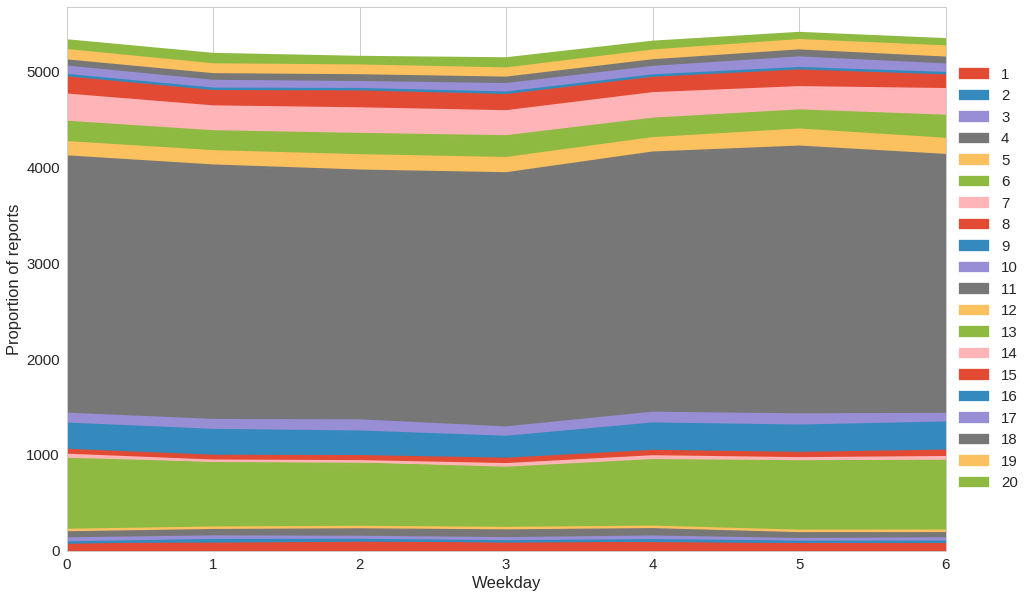

In [90]:
df = lfb_free_text
df = df[['weekday','topic']].pivot_table(index='weekday', columns='topic', aggfunc=len, fill_value=0)
df.index.name = None
ax = df.plot.area(figsize=(15, 10));
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.05, box.height])
ax.set(xlabel='Weekday', ylabel='Proportion of reports')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Normalised kde - topic occurence by year

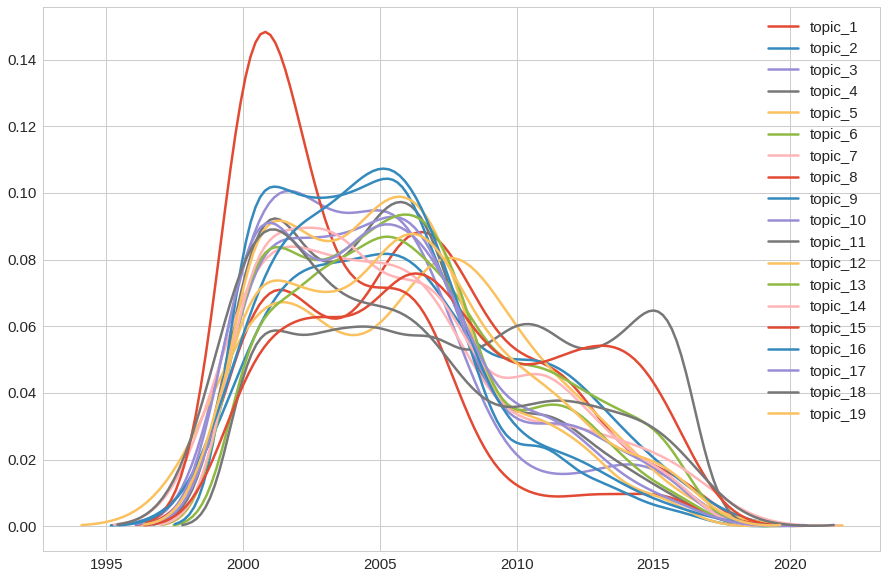

In [91]:
df = lfb_free_text
plt.figure(figsize=(15, 10))
for i in range(1,df.topic.max()):
    df2 = df[df.topic == i] 
    sns.kdeplot(df2.year, label='topic_'+str(i))

## Normalised kde - topic occurence by month

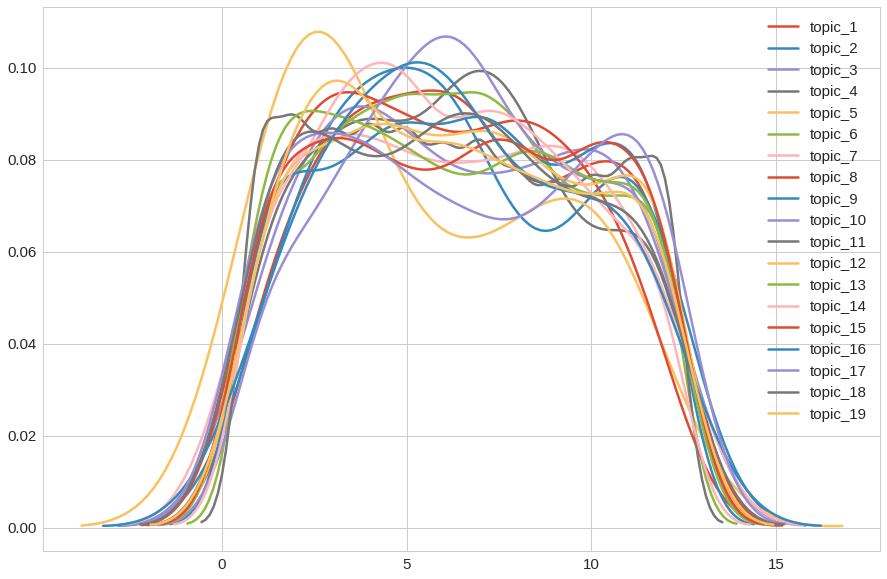

In [92]:
df = lfb_free_text
plt.figure(figsize=(15, 10))
for i in range(1,df.topic.max()):
    df2 = df[df.topic == i] 
    sns.kdeplot(df2.month, label='topic_'+str(i))

## Normalised kde - topic occurence by weekeday

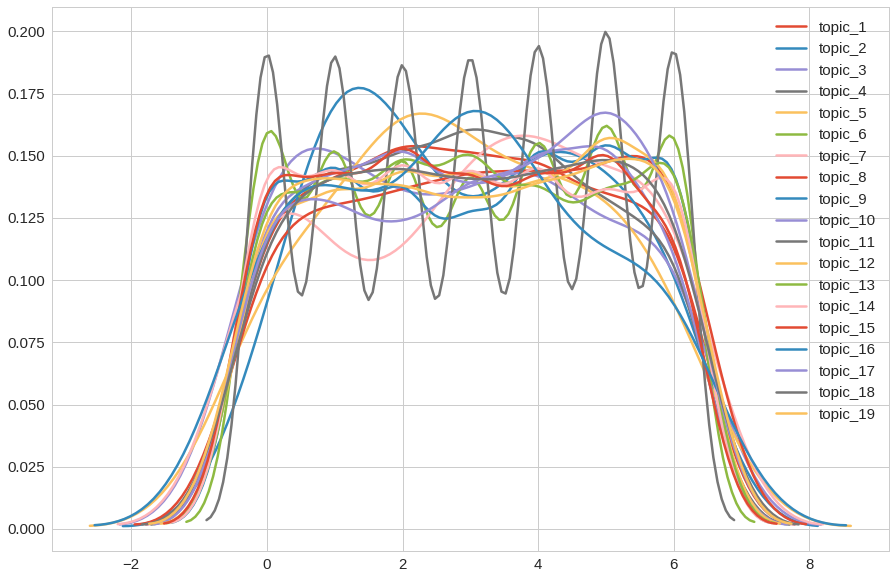

In [93]:
df = lfb_free_text
plt.figure(figsize=(15, 10))
for i in range(1,df.topic.max()):
    df2 = df[df.topic == i] 
    sns.kdeplot(df2.weekday, label='topic_'+str(i))

## Facet wrap topic - action based

In [94]:
df = lfb_free_text[['topic','ActionBased']]
mapping = {'None': 0, 'Small': 1, 'Medium': 2, 'Large': 3, '5+': 4}
print(mapping)
df['ActionBased'] = df.ActionBased.map(mapping)

{'Medium': 2, '5+': 4, 'None': 0, 'Small': 1, 'Large': 3}


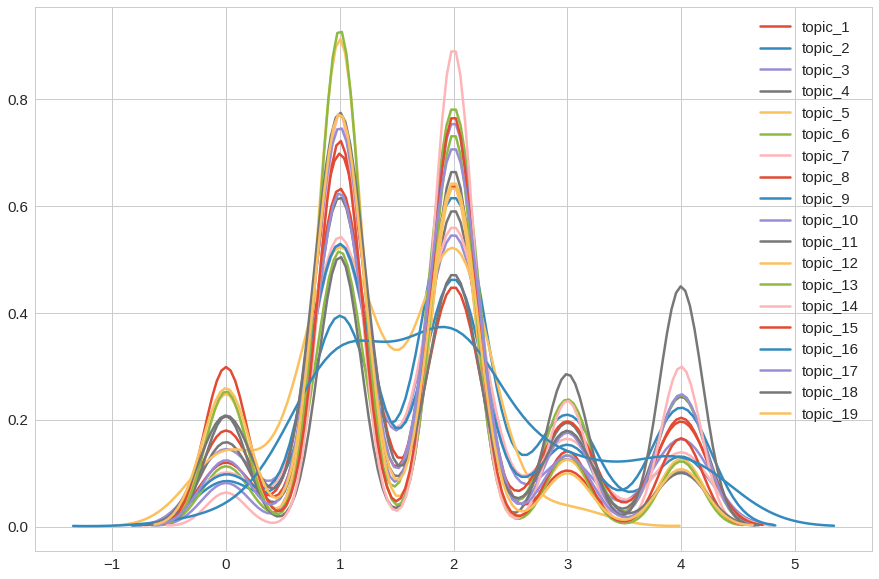

In [95]:
plt.figure(figsize=(15, 10))
for i in range(1,df.topic.max()):
    df2 = df[df.topic == i] 
    sns.kdeplot(df2.ActionBased, label='topic_'+str(i))